In [22]:
import numpy as np
from scipy import stats
import rpy2.robjects as robjects
import matplotlib.pyplot as plt
import time
import sklearn
import os
os.chdir('../Wehbe')

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
subs = ['1','2','3','4','5','6','7','8']
context_disp = ['0','1','2','4','16','1600']
contexts = ['0s_','1s_','2s_','4s_','16s_','1600s_']
dec = "sl5000"

In [3]:
sub = '1'
context = '0s_'
layer = 'layer1'
if layer == 'layer1':
    path_to_embeddings = '../Wehbe/'
else:
    path_to_embeddings = '/gpfs/milgram/project/chun/kxt3/official/glove/'
robjects.r['load'](path_to_embeddings+'TR_'+layer+'_context_embeddings.RData')
actual=np.array(robjects.r['layer1_' + context])

In [4]:
!ls -l '../Wehbe/subject1_'+dec+'_0s_decoded.npy'

ls: cannot access ../Wehbe/subject1_+dec+_0s_decoded.npy: No such file or directory


In [5]:
decoded=np.load('../Wehbe/subject'+sub+'_'+dec+'_layer1_'+context+'decoded.npy')

In [6]:
decoded.shape

(1295, 1024)

In [7]:
actual.shape

(1295, 1024)

In [8]:
# In the returned matrix, the rows are A, the columns are B
def corr2_coeff(A,B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:,None]
    B_mB = B - B.mean(1)[:,None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1);
    ssB = (B_mB**2).sum(1);

    # Finally get corr coeff
    return np.dot(A_mA,B_mB.T)/np.sqrt(np.dot(ssA[:,None],ssB[None]))

In [9]:
cross = corr2_coeff(decoded, actual)

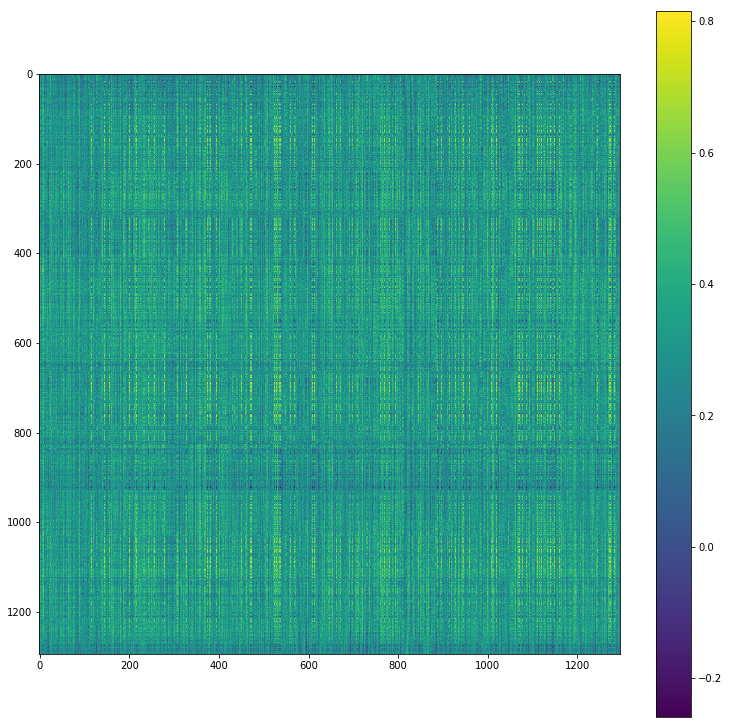

In [10]:
plt.figure(figsize=(13,13))
plt.imshow(cross)
plt.colorbar()

In [11]:
# number of pairs with match > mismatch
sum([sum([cross[row, col] < cross[row, row] for col in range(cross.shape[1])]) for row in range(cross.shape[0])])

865832

In [12]:
# total number of pairs
npairs = 1295*1295-1295
npairs

1675730

wrapper

In [13]:
t1=time.time()
acc = np.sum([[cross[row, col] < cross[row, row] for col in range(cross.shape[1])] for row in range(cross.shape[0])])/npairs
print(acc)
print(time.time()-t1)

0.5166894428099992
0.8358078002929688


In [16]:
t1=time.time()
acc = np.sum(cross.T<np.diagonal(cross))/npairs
print(acc)
print(time.time()-t1)

0.5166894428099992
0.017462491989135742


In [23]:
lstm_accs = np.zeros((len(subs),len(contexts)))
for i,sub in enumerate(subs):
    print('Subject ' + sub)
    for j,context in enumerate(contexts):
        robjects.r['load'](path_to_embeddings+'TR_layer1_context_embeddings.RData')
        actual=np.array(robjects.r['layer1_' + context])
        decoded=np.load('../Wehbe/subject'+sub+'_'+dec+'_layer1_'+context+'decoded.npy')
        start = time.time()
        cross = corr2_coeff(decoded, actual)
        mid = time.time()
        acc = np.sum(cross.T<np.diagonal(cross))/npairs
        #permutation test
        perms = []
        for k in range(1000):
            np.random.shuffle(np.transpose(cross))
            perms.append(np.sum(cross.T<np.diagonal(cross))/npairs)
        print('Context ' + context + ': ' + str(acc) + ', p = ' + str(np.mean(perms > acc)))
        lstm_accs[i,j] = acc

Subject 1
Context 0s_: 0.5166894428099992, p = 0.004
Context 1s_: 0.5291472969989198, p = 0.0
Context 2s_: 0.5335632828677651, p = 0.0
Context 4s_: 0.5311643283822572, p = 0.0
Context 16s_: 0.5198068901314651, p = 0.0
Context 1600s_: 0.5246119601606464, p = 0.0
Subject 2
Context 0s_: 0.5132306517159686, p = 0.022
Context 1s_: 0.5149081295912826, p = 0.011
Context 2s_: 0.5067170725594219, p = 0.182
Context 4s_: 0.5035703842504461, p = 0.304
Context 16s_: 0.49131244293531773, p = 0.892
Context 1600s_: 0.49702458033215374, p = 0.684
Subject 3
Context 0s_: 0.5170994133899852, p = 0.004
Context 1s_: 0.5405793296056047, p = 0.0
Context 2s_: 0.5420366049423236, p = 0.0
Context 4s_: 0.5435511687443682, p = 0.0
Context 16s_: 0.5324783825556623, p = 0.0
Context 1600s_: 0.5282247140052395, p = 0.0
Subject 4
Context 0s_: 0.5462246304595609, p = 0.0
Context 1s_: 0.5606183573726078, p = 0.0
Context 2s_: 0.5616346308772893, p = 0.0
Context 4s_: 0.553352270353816, p = 0.0
Context 16s_: 0.5470684418134

Text(0.5,1,'LSTM - pairwise classification performance')

/gpfs/milgram/project/chun/hf246/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


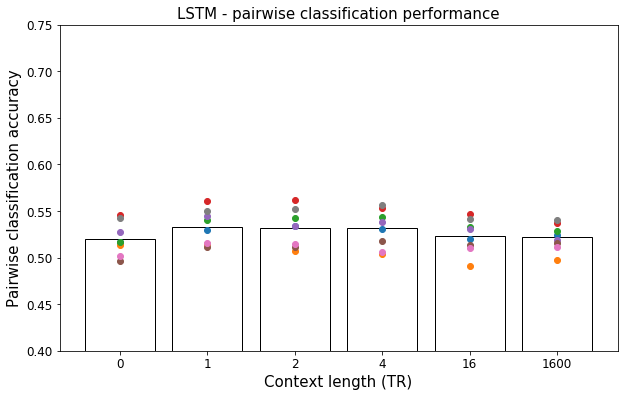

In [64]:
plt.figure(figsize=(10,6))
plt.plot(lstm_accs.T, marker = 'o',linestyle='')
plt.bar([0,1,2,3,4,5],np.mean(lstm_accs.T, axis=1), fill=False)
plt.ylim(top=0.75, bottom=0.4)
plt.xticks([0,1,2,3,4,5],context_disp)
plt.ylabel('Pairwise classification accuracy')
plt.xlabel('Context length (TR)')
plt.title('LSTM - pairwise classification performance')

In [15]:
np.save(file='../Wehbe/lstm_pairwise_accs', arr=lstm_accs)

now also do for glove

In [65]:
glove_accs = np.zeros((len(subs),len(contexts)-1))
for i,sub in enumerate(subs):
    print('Subject ' + sub)
    for j,context in enumerate(contexts[:-1]):
        robjects.r['load']('/gpfs/milgram/project/chun/kxt3/official/glove/TR_glove_context_embeddings.RData')
        actual=np.array(robjects.r['glove_' + context])
        decoded=np.load('subject'+sub+'_'+dec+'_glove_'+context+'decoded.npy')
        start = time.time()
        cross = corr2_coeff(decoded, actual)
        mid = time.time()
#        print('Computing cross took ' + str(mid-start) + 's')
        acc = sum([sum([cross[row, col] < cross[row, row] for col in range(cross.shape[1])]) for row in range(cross.shape[0])])/npairs
#        print('Counting took ' + str(time.time()-mid) + 's')
#        print(acc)
        for k in range(1000):
            np.random.shuffle(np.transpose(cross))
            perms.append(np.sum(cross.T<np.diagonal(cross))/npairs)
        print('Context ' + context + ': ' + str(acc)  + ', p = ' + str(np.mean(perms > acc)))
        glove_accs[i,j] = acc

Subject 1
Context 0s_: 0.5436824548107392, p = 0.0
Context 1s_: 0.6020641750162615, p = 0.0
Context 2s_: 0.601960339672859, p = 0.0
Context 4s_: 0.5565532633538816, p = 0.0
Context 16s_: 0.4664641678552034, p = 1.0
Subject 2
Context 0s_: 0.531716326615863, p = 0.0
Context 1s_: 0.5628263503070303, p = 0.0
Context 2s_: 0.5495598933002334, p = 0.0
Context 4s_: 0.5250129794179254, p = 0.0
Context 16s_: 0.4601690009727104, p = 1.0
Subject 3
Context 0s_: 0.5567609340406867, p = 0.0
Context 1s_: 0.6286376683594612, p = 0.0
Context 2s_: 0.6540254098213912, p = 0.0
Context 4s_: 0.620765875170821, p = 0.0
Context 16s_: 0.5075334331903111, p = 0.0750625
Subject 4
Context 0s_: 0.578444618166411, p = 0.0
Context 1s_: 0.6555519087203786, p = 0.0
Context 2s_: 0.6577079839830999, p = 0.0
Context 4s_: 0.5998890035984318, p = 0.0
Context 16s_: 0.4670585356829561, p = 1.0
Subject 5
Context 0s_: 0.5625273761286126, p = 0.0
Context 1s_: 0.6051195598336248, p = 0.0
Context 2s_: 0.6195252218436145, p = 0.0
C

Text(0.5,1,'GloVe - pairwise classification performance')

/gpfs/milgram/project/chun/hf246/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


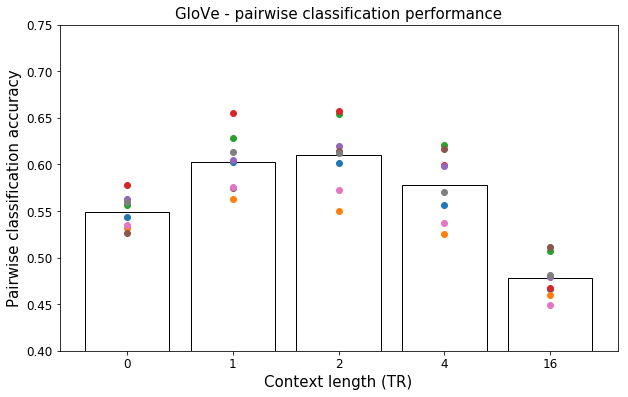

In [69]:
plt.figure(figsize=(10,6))
plt.plot(glove_accs.T, marker = 'o',linestyle='')
plt.bar([0,1,2,3,4],np.mean(glove_accs.T, axis=1), fill=False)
plt.ylim(top=0.75, bottom=0.4)
plt.xticks([0,1,2,3,4],context_disp[:-1])
plt.ylabel('Pairwise classification accuracy')
plt.xlabel('Context length (TR)')
plt.title('GloVe - pairwise classification performance')

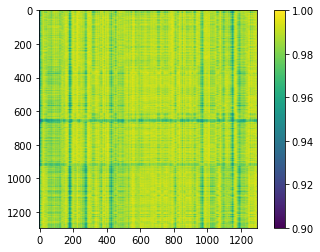

In [18]:
plt.imshow(cross, vmin=0.9, vmax=1)
plt.colorbar()

In [19]:
#Really?
[cross[100, col] - cross[100, 100] for col in range(cross.shape[1])]

[-0.13342511468994,
 -0.052721648969972335,
 -0.04694667991743762,
 -0.02852958494675817,
 -0.028147386118640316,
 -0.025637393427362154,
 -0.0289794632591186,
 -0.020912365281344547,
 -0.019756003283957213,
 -0.017187225229624903,
 -0.011056611554939422,
 -0.012615916083641654,
 -0.010627277831941062,
 -0.008106044670994406,
 -0.0071589908520207635,
 -0.005170367734636416,
 -0.005078265986067976,
 -0.002174121402918283,
 -0.0045922702069596255,
 -0.005262657971520257,
 -0.0024333471439937915,
 -0.002953138107225528,
 -0.001907269380670873,
 5.557171580661269e-05,
 -6.49286547081962e-05,
 0.0016391694895011577,
 0.001802769966280482,
 0.00039709516257591115,
 2.0515906855367305e-05,
 -0.001265684004362888,
 -0.0030077713238232384,
 -0.0021169402423323325,
 -0.0037759896879279164,
 -0.0029428419683453777,
 -0.00446752229544467,
 -0.002955571832538584,
 -0.003936570488520363,
 -0.005835133258707881,
 -0.004641910706562946,
 -0.004145642571507735,
 -0.004512835523360237,
 -0.0052813967281

In [20]:
np.save(file='../Wehbe/glove_pairwise_accs', arr=glove_accs)

In [14]:
def average_reconstructions(layer, context):
    if layer == 'layer1':
        nnode = 1024
    else:
        nnode = 300        
    average_decoded = np.zeros((1295, nnode))    
    for sub in subs:
        average_decoded = average_decoded + np.load('subject'+sub+'_'+dec+'_'+layer+'_'+context+'decoded.npy')
    average_decoded = average_decoded / len(subs)  
    
    return average_decoded

In [19]:
avg_glove_accs = []
for j,context in enumerate(contexts[:-1]):
    robjects.r['load']('/gpfs/milgram/project/chun/kxt3/official/glove/TR_glove_context_embeddings.RData')
    actual=np.array(robjects.r['glove_' + context])
    decoded=average_reconstructions('glove',context)
    start = time.time()
    cross = corr2_coeff(decoded, actual)
    mid = time.time()
#        print('Computing cross took ' + str(mid-start) + 's')
    acc = np.sum(cross.T<np.diagonal(cross))/npairs
#        print('Counting took ' + str(time.time()-mid) + 's')
#        print(acc)
    perms = []
    for k in range(1000):
        np.random.shuffle(np.transpose(cross))
        perms.append(np.sum(cross.T<np.diagonal(cross))/npairs)
    print('Context ' + context + ': ' + str(acc) + ', p = ' + str(np.mean(perms > acc)))
    avg_glove_accs.append(acc)

Context 0s_: 0.5571977585887942, p = 0.0
Context 1s_: 0.622180780913393, p = 0.0
Context 2s_: 0.635658489136078, p = 0.0
Context 4s_: 0.6024443078538906, p = 0.0
Context 16s_: 0.47513083850023574, p = 1.0


Text(0.5,1,'Averaged GloVe - pairwise classification performance')

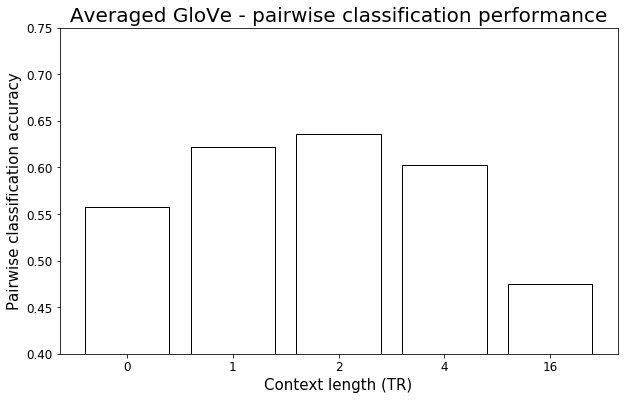

In [23]:
plt.figure(figsize=(10,6))
plt.bar([0,1,2,3,4],avg_glove_accs, fill=False)
plt.ylim(top=0.75, bottom=0.4)
plt.xticks([0,1,2,3,4],context_disp[:-1])
plt.ylabel('Pairwise classification accuracy')
plt.xlabel('Context length (TR)')
plt.title('Averaged GloVe - pairwise classification performance')

In [24]:
avg_lstm_accs = []
for j,context in enumerate(contexts):
    robjects.r['load'](path_to_embeddings+'TR_'+layer+'_context_embeddings.RData')
    actual=np.array(robjects.r['layer1_' + context])
    decoded=average_reconstructions('layer1', context)
    start = time.time()
    cross = corr2_coeff(decoded, actual)
    mid = time.time()
#        print('Computing cross took ' + str(mid-start) + 's')
    acc = np.sum(cross.T<np.diagonal(cross))/npairs
#        print('Counting took ' + str(time.time()-mid) + 's')
#        print(acc)
    perms = []
    for k in range(1000):
        np.random.shuffle(np.transpose(cross))
        perms.append(np.sum(cross.T<np.diagonal(cross))/npairs)
    print('Context ' + context + ': ' + str(acc) + ', p = ' + str(np.mean(perms > acc)))
    avg_lstm_accs.append(acc)

Context 0s_: 0.5316542641117602, p = 0.0
Context 1s_: 0.5504788957648309, p = 0.0
Context 2s_: 0.5514993465534423, p = 0.0
Context 4s_: 0.5504932178811622, p = 0.0
Context 16s_: 0.5390420891193689, p = 0.0
Context 1600s_: 0.5369313672250303, p = 0.0


Text(0.5,1,'Averaged LSTM - pairwise classification performance')

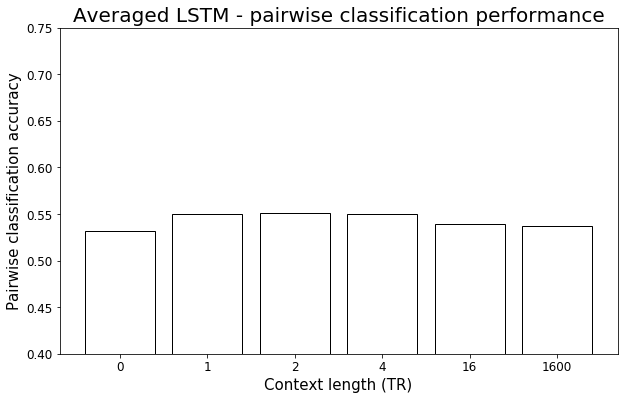

In [30]:
plt.figure(figsize=(10,6))
plt.bar([0,1,2,3,4,5],avg_lstm_accs, fill=False)
plt.ylim(top=0.75, bottom=0.4)
plt.xticks([0,1,2,3,4,5],context_disp)
plt.ylabel('Pairwise classification accuracy')
plt.xlabel('Context length (TR)')
plt.title('Averaged LSTM - pairwise classification performance')